In [ ]:
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

data = load_dataset("SeaLLMs/TrueFalse-Statements-multilingual")["test"]
statements = data["statements"]

def encode(texts, batch_size = 50, template = True):
    model.eval()
    token_representations = []
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch = texts[start_index: start_index+batch_size]
        if template:
            messages_list = [
                [   {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ] for prompt in batch
            ]
            inputs = [tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True) for messages in messages_list]
            model_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(model.device)
        else:
            model_inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model(**model_inputs, output_hidden_states=True)

        hidden_states = outputs.hidden_states 
        layer_hidden_states = hidden_states[20]
        if template:
            last_token_states = layer_hidden_states[:,-6,:].cpu()
        else:
            last_token_states = layer_hidden_states[:,-1,:].cpu()
        token_representations.append(last_token_states)
    token_representations = torch.vstack(token_representations)
    return token_representations

model_name = 'Qwen/Qwen2.5-7B-Instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype="auto",
    device_map="auto"
)

reps = encode(statements)
reps = reps.to(torch.float16)

categories = data["category"]
truefalse = [str(x) for x in data["true/false"]]
languages = data["language"]
finegrained_label_words = [c+"-"+t for c,t in zip(categories, truefalse)]

topic_label_dict = {x:i for x, i in zip(np.unique(finegrained_label_words), range(12))}
language_label_dict = {'English':0,
 'French':1,
 'German':2,
 'Hindi':3,
 'Italian':4,
 'Portuguese':5,
 'Spanish':6,
 'Thai':7}
truefalse_label_dict = {'False':0,
 'True':1}

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(reps, finegrained_label_words)
lda = LinearDiscriminantAnalysis()
X_lda_language = lda.fit_transform(reps, [language_label_dict[x] for x in languages])
lda = LinearDiscriminantAnalysis()
X_lda_truth = lda.fit_transform(reps, [truefalse_label_dict[x] for x in truefalse])

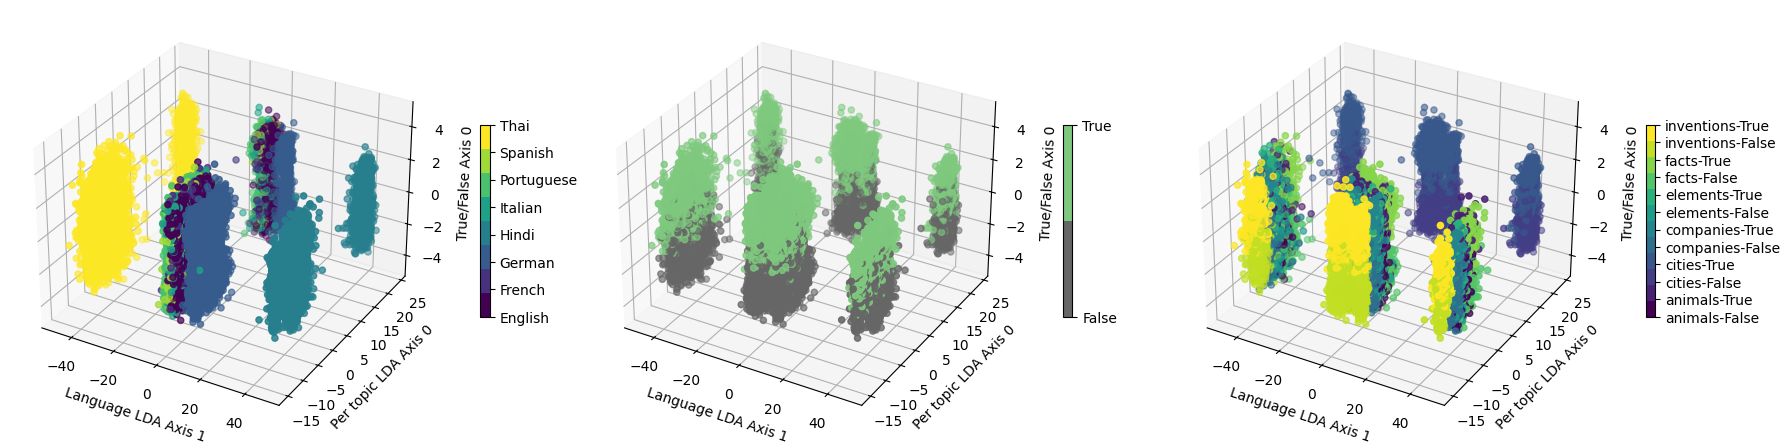

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10), dpi=100, subplot_kw={'projection': '3d'})

accent_cmap = plt.get_cmap('Accent')
colors = np.vstack((np.array(accent_cmap(7)), np.array(accent_cmap(0))))
cmap_discrete = ListedColormap(colors)

# colors for true
n_classes = len(np.unique(finegrained_label_words))
viridis_cmap = plt.get_cmap('viridis')
colors = viridis_cmap(np.linspace(0, 1, n_classes))
cmap_discrete1 = ListedColormap(colors)
# colors for languages
n_classes = len(np.unique(languages))
viridis_cmap = plt.get_cmap('viridis')
colors = viridis_cmap(np.linspace(0, 1, n_classes))
cmap_discrete2 = ListedColormap(colors)
# colors for true/false
accent_cmap = plt.get_cmap('Accent')
colors = np.vstack((np.array(accent_cmap(7)),
np.array(accent_cmap(0))))
cmap_discrete3 = ListedColormap(colors)

plots_data = [
    (-X_lda_language[:,1], X_lda[:, 0], X_lda_truth[:, 0], [language_label_dict[x] for x in languages], "Plot 2", cmap_discrete2, language_label_dict.keys()),
    (-X_lda_language[:,1], X_lda[:, 0], X_lda_truth[:, 0], [truefalse_label_dict[x] for x in truefalse], "Plot 3", cmap_discrete3, ["False", "True"]),
    (-X_lda_language[:,1], X_lda[:, 0], X_lda_truth[:, 0], [topic_label_dict[x] for x in finegrained_label_words], "Plot 1", cmap_discrete1, topic_label_dict.keys()),
]

for ax, (x, y, z, labels, title, cmap_discrete, label_words) in zip(axes, plots_data):
    scatter = ax.scatter(x, y, z, c=labels, cmap=cmap_discrete)
    ax.set_xlabel('Language LDA Axis 1')
    ax.set_ylabel('Per topic LDA Axis 0')
    ax.set_zlabel('True/False Axis 0')

    cbar = fig.colorbar(scatter, ax=ax, fraction=0.02, pad=0.1)
    cbar.set_ticks(np.arange(len(np.unique(labels))))
    cbar.set_ticklabels(label_words)

plt.tight_layout()
plt.show()
# plt.savefig("./visualization/LDA.pdf")